Replicating fastai caravana challenge notebook for datascience bowl

In [59]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [60]:
import sys 

In [61]:
sys.path.append('../../../fastai/')

In [62]:
from utility.utils import *

In [63]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
#torch.cuda.set_device(1)

In [64]:
PATH = Path('../data/ds_bowl_2018/')
list(PATH.iterdir())

[PosixPath('../data/ds_bowl_2018/train_masks_png'),
 PosixPath('../data/ds_bowl_2018/dummy'),
 PosixPath('../data/ds_bowl_2018/full_data'),
 PosixPath('../data/ds_bowl_2018/train'),
 PosixPath('../data/ds_bowl_2018/train-128'),
 PosixPath('../data/ds_bowl_2018/train_masks-128'),
 PosixPath('../data/ds_bowl_2018/models'),
 PosixPath('../data/ds_bowl_2018/csv'),
 PosixPath('../data/ds_bowl_2018/valid'),
 PosixPath('../data/ds_bowl_2018/test')]

In [65]:
CSV_DN = 'csv'
TRAIN_DN = 'full_data' 

In [66]:
CSV_FILES = list((PATH/CSV_DN).iterdir())

In [67]:
masks_csv = pd.read_csv(CSV_FILES[1])
masks_csv.head()

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3


In [68]:
NUCLEI_ID = '58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd'

In [69]:
list((PATH/TRAIN_DN).iterdir())[:5]

[PosixPath('../data/ds_bowl_2018/full_data/58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd'),
 PosixPath('../data/ds_bowl_2018/full_data/8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832'),
 PosixPath('../data/ds_bowl_2018/full_data/c9f305be17312bdb9530fb4f1adc6d29730ddbe0e74730cbf031de174bf437b7'),
 PosixPath('../data/ds_bowl_2018/full_data/5908488d940e846cc121c768758da9b1bd5b9922417e20c9101a4e254fa98af8'),
 PosixPath('../data/ds_bowl_2018/full_data/2f929b067a59f88530b6bfa6f6889bc3a38adf88d594895973d1c8b2549fd93d')]

In [70]:
NUCLEI_IDS = [str(TRAIN_DIR).split('/')[-1] for TRAIN_DIR in list((PATH/TRAIN_DN).iterdir())]

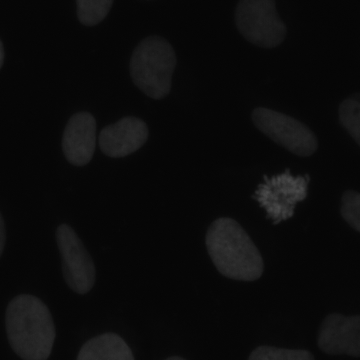

In [71]:
Image.open(PATH/TRAIN_DN/f'{NUCLEI_ID}/images/{NUCLEI_ID}.png')

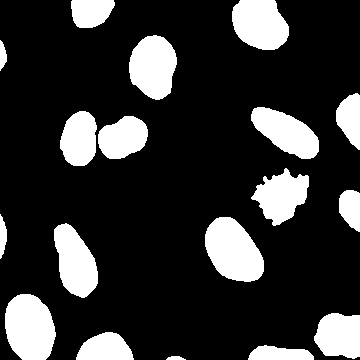

In [72]:
Image.open(PATH/TRAIN_DN/f'{NUCLEI_ID}/one_mask.png')

In [73]:
ims = [open_image(PATH/TRAIN_DN/f'{NUCLEI_ID}/images/{NUCLEI_ID}.png')
       for NUCLEI_ID in NUCLEI_IDS[:16]]

In [74]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

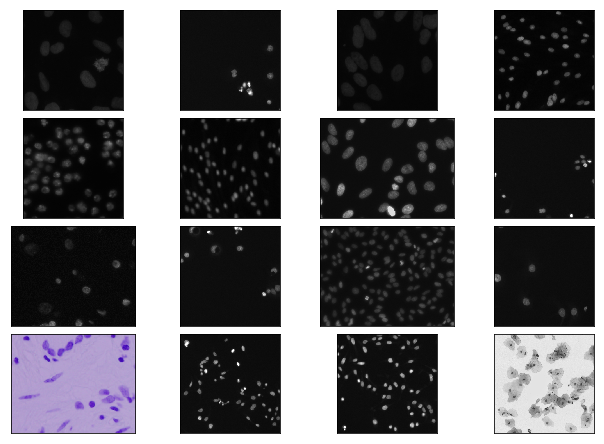

In [75]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

In [76]:
# TOTAL NUMBER OF IMAGES WITH MASK LABELS
n = len(list((PATH/TRAIN_DN).iterdir()))
n

670

### Resize and Convert

In [180]:
TRAIN_DN = 'full_data' 

In [181]:
(PATH/'train_masks_png').mkdir(exist_ok=True)

In [182]:
TRAIN_DIRS = list((PATH/TRAIN_DN).iterdir())

In [183]:
MASK_FN = [str(list(TRAIN_DIR.iterdir())[1]) for TRAIN_DIR in TRAIN_DIRS]

In [184]:
def copy_masks(fn):
    NUCLEI_DN = fn.split('/')[-2]
    Image.open(fn).save(PATH/'train_masks_png'/f'{NUCLEI_DN}.png')

In [185]:
with ThreadPoolExecutor(8) as e: e.map(copy_masks, MASK_FN)

In [186]:
(PATH/'train_masks-256').mkdir(exist_ok=True)

In [187]:
def resize_mask(fn):
    Image.open(str(fn)).resize((256,256)).save((fn.parent.parent)/'train_masks-256'/fn.name)

files = list((PATH/'train_masks_png').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [188]:
(PATH/'train-256').mkdir(exist_ok=True)

In [189]:
IMAGE_FN = [str(list((list(TRAIN_DIRS[i].iterdir())[0]).iterdir())[0]) for i in range(len(TRAIN_DIRS))]

In [190]:
def resize_img(fn):
    Image.open(fn).resize((256,256)).save((PATH)/'train-256'/fn.split('/')[-1])

In [191]:
with ThreadPoolExecutor(8) as e: e.map(resize_img, IMAGE_FN)

### Dataset

In [192]:
TRAIN_DN = 'train-256'
MASKS_DN = 'train_masks-256'
sz = 256
bs = 64

In [193]:
TRAIN_IMG = list((PATH/TRAIN_DN).iterdir())
TRAIN_MASK = list((PATH/MASKS_DN).iterdir())

In [194]:
open_image(TRAIN_IMG[0]).shape

(256, 256, 3)

In [196]:
ims = [open_image(f'{str(TRAIN_IMG[i])}') for i in range(16)]
im_masks = [open_image(f'{str(TRAIN_MASK[i])}') for i in range(16)]

In [197]:
def show_img(im, figsize=None, ax=None, alpha=1):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

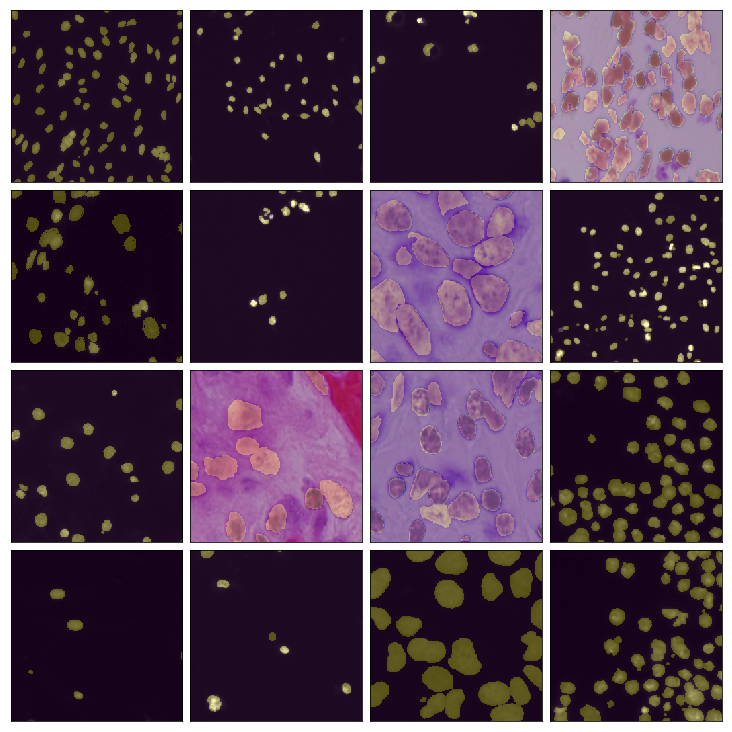

In [201]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.3)
plt.tight_layout(pad=0.1)

In [202]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [266]:
x_names = np.array([Path(TRAIN_DN)/f'{o}.png' for o in masks_csv['ImageId'].unique()])
y_names = np.array([Path(MASKS_DN)/f'{o}.png' for o in masks_csv['ImageId'].unique()])

In [267]:
len(y_names), len(x_names)

(670, 670)

In [268]:
train_ids = masks_csv['ImageId'].unique()

In [269]:
from dataset.validation import *

In [270]:
classes = pd.read_csv('classes.csv')
train_dirs, valid_dirs = get_stratified_valid_dirs(classes, seed=17)

In [273]:
trn_x = [x_name for x_name in x_names if x_name.name.split('.')[0] in train_dirs]
val_x = [x_name for x_name in x_names if x_name.name.split('.')[0] in valid_dirs]
trn_y = [y_name for y_name in y_names if y_name.name.split('.')[0] in train_dirs]
val_y = [y_name for y_name in y_names if y_name.name.split('.')[0] in valid_dirs]

In [274]:
len(val_x),len(trn_x), len(val_y),len(trn_y)

(64, 606, 64, 606)

In [275]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]

In [276]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [278]:
img, msk = md.trn_ds.__getitem__(0)

In [284]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

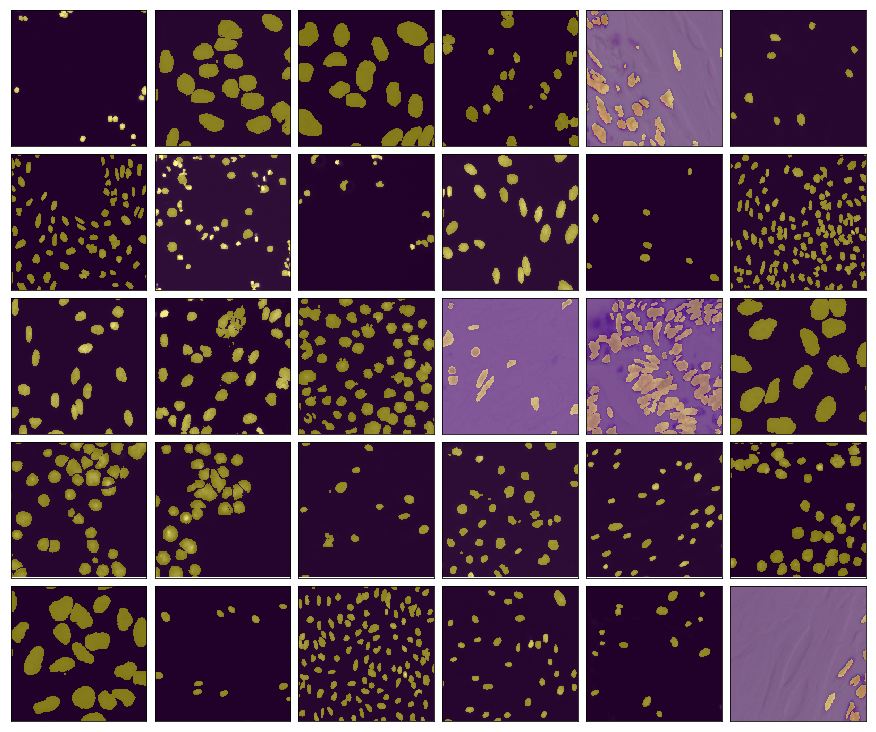

In [285]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

### Model

In [286]:
class Empty(nn.Module): 
    def forward(self,x): return x

models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
learn = ConvLearner(md, models)
learn.summary()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/kerem/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [02:27<00:00, 590449.12it/s]


OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 256, 256]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 64, 

In [287]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [288]:
flatten_channel = Lambda(lambda x: x[:,0])

In [289]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [290]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [ ]:
learn.lr_find()
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 10%|█         | 1/10 [00:39<05:58, 39.82s/it, loss=0.694]